# Projet Simulation Numérique ENSEEIHT 2020-2021
### Groupe: HPC Big Data
### Nom: Sajid
### Prénom: Badr

# Informations pratiques

**Modalités pédagogiques** 

Le projet Simulation Numérique vise à vous faire découvrir un algorithme particulier en lien avec d'autres modules d'enseignement de cette année et d'illustrer certaines notions et propriétés à partir de programmes simples que vous devez écrire ou bien compléter. Le langage de programmation proposé est Python. Une connaissance basique de Python et de Numpy est suffisante. 

Cette année, il vous est demandé en premier lieu un travail de compréhension des algorithmes principaux sur la base du C/TD du 6/4/21 et des liens en fin de Notebook. Ensuite est demandé un travail d'implantation informatique simple (partie A) et quelques applications sur des données synthétiques ou pratiques vous sont proposées (partie B). Ce travail est notamment guidé, des questions de compréhension sont enfin posées en Partie C. Le volume de travail demandé est raisonnable.

**Enseignement à distance**

Voici les informations concernant les séances à distance (date, heure, lien, numéro de réunion, mot de passe):

06/4/21 08.00-09.45 https://zoom.us/j/3060702500?pwd=T2Fya0JCRHExeHpFRTVDNC9CanUwUT09  306 070 2500 86KhS8

16/4/21 08.00-11.45 https://zoom.us/j/3060702500?pwd=T2Fya0JCRHExeHpFRTVDNC9CanUwUT09  306 070 2500 86KhS8

04/5/21 10.00-11.45 https://zoom.us/j/3060702500?pwd=T2Fya0JCRHExeHpFRTVDNC9CanUwUT09  306 070 2500 86KhS8


**Evaluation**

L'évaluation se basera uniquement sur le Notebook que vous devrez rendre. 

**Date limite de rendu**:  12 mai 2021

**Contact**: xavier.vasseur@isae-supaero.fr

Merci d'indiquer [N7-PSN] en sujet de votre email pour m'aider à identifier vos requêtes.

**Préambule** L'objectif de ce projet est d'analyser quelques algorithmes de factorisation structurée (déterministe ou aléatoire) de matrices de grande taille. Nous nous intéressons à des algorithmes de factorisation dits "Interpolative Decomposition (ID)" ou "CUR-ID", où l'on cherche à approcher au mieux une matrice en un produit de matrices de rang faible. Les algorithmes seront comparés si possible sous différents angles: temps de calcul, complexité opératoire, précision numérique notamment. 

**NB:** Il vous est demandé d'insérer vos commentaires et codes **uniquement** dans ce fichier Notebook. Vous avez toute liberté pour créer des cellules soit de texte soit de code. Vous devez disposer comme données de ce fichier et de quelques images au format .jpg. Le rendu sera uniquement ce fichier Notebook dans lequel vous devez insérer l'ensemble de vos résultats. 

Ce projet est en lien notamment avec les cours suivants:

   * Calcul scientifique
   * Analyse de données
   * Optimisation II

In [12]:
#
# Chargement des bibliotheques pour la visualisation, l'algebre lineaire et l'analyse du temps de calcul 
#
import matplotlib.pyplot as plt
import numpy as np
from   scipy import fftpack
from   scipy.linalg import qr, norm, solve_triangular, svd
from   PIL import Image
import time

### Introduction.

L'approximation de rang faible que nous utiliserons dans ce projet se base sur une connaissance du rang exact ou du rang approché de la matrice étudiée. A titre informatif, la méthode suivante vous permet d'obtenir une majoration du rang d'une matrice rectangulaire $A$ telle que $ \|A - Q Q^T A \|_F \le \epsilon \|A \|_F$, $\epsilon$ désignant une tolérance choisie par l'utilisateur. Cette méthode sera donc utile par la suite dans vos expérimentations numériques, aucune modification n'est a priori requise.  


In [13]:
def adaptive_rank_determination(A,epsilon,blocking=16):
    """
    Adaptive rank determination based on randomization
    We look for an orthogonal matrix Q such that 
    $\|A - Q Q^T A \|_F \le \epsilon \|A \|_F$
    where $\|.\|_F$ denotes the Frobenius norm.
    
    Reference: Adapted from Section 12 of P.G. Martinsson, "Randomized methods for matrix computations", 2019, 
    ArXiv 1607.01649 [https://arxiv.org/pdf/1607.01649.pdf]. The original algorithm corresponds to 
    Figure 12. 
    
    Input: 
    A:        matrix to be analysed [array type] (of shape (m,n))
    epsilon:  relative threshold related to the accuracy of the projection (in the Frobenius norm) (0<= epsilon <= 1)
    blocking: blocking parameter to be used in the implementation (for efficiency reasons) [int]
    
    Output:
    Q: matrix with orthonormal columns such that $ \|A - Q Q^T A \|_F \le \epsilon \|A \|_F$
    erank: estimated rank (upper bound of rank(A)), erank is here a multiple of min(blocking,n). 
    """ 
    
    m, n       = A.shape[:]
    b          = min(blocking,n)
    iteration  = 0
    norm_A_Fro = norm(A)
    
    while norm(A) > epsilon*norm_A_Fro:
        # Create R the random block based on Gaussian variables
        R      = np.random.randn(n,b)
        # Matrix-matrix product Y = AR 
        Y      = A@R
        # QR decomposition of Y
        QY, RY = qr(Y,mode='economic')
        # Compute the projection 
        BY     = QY.T@A
        # Concatenate the information related to Q and B
        if iteration == 0:
            Q  = QY
            B  = BY
        else:
            Q  = np.concatenate((Q, QY),axis=1)
            B  = np.concatenate((B, BY),axis=0)
        # Update the iteration count
        iteration += 1
        # Update of A
        A = A - QY@BY
        # Upper bound of rank
        erank = Q.shape[1]
        
    return Q, erank

## Partie A.1

Proposer une implantation des différents algorithmes de décomposition vus en cours. Pour vous aider, une définition des fonctions et leurs squelettes sont proposés. Vous avez toute liberté pour les modifier. Ces algorithmes seront utilisés dans la partie de validation (Partie B) et applicative du Notebook (Partie C). Vous pourrez vous appuyer sur les <a href="https://arxiv.org/pdf/1607.01649.pdf">chapitres 10 et 11 des notes de cours de P.G. Martinsson</a>:


In [44]:
def column_ID(A,k):
    """
    Compute a column interpolative decomposition such that 
    A \approx A[:,J] Z
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    k: estimated rank of matrix A [int]
    
    Output:
    J  is the set of column indices [array, any type] (of shape k)
    Z  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    
    m, n = A.shape[:]
    Z    = np.zeros(shape=(k,n))
    
    # Perform the economic decomposition of A with column pivoting 
    Q, S, J = qr(A, mode='economic', pivoting=True)
    
    # Deduce the T=R11^{-1}R12 block 
    T = np.linalg.inv(S[:k, :k]) @ S[:k, k:n]
    
    # Deduce J and Z 
    Z[:,J] = np.concatenate((np.eye(k), T), axis=1)
    J = J[:k]
        
    return J,Z


def row_ID(A,k):
    """
    Compute a row interpolative decomposition such that 
    A \approx X A[I,:] 
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    
    Output:
    I  is the set of row indices [array, any type] (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    
    m, n = A.shape[:]
    X    = np.zeros(shape=(m,k))
    
    # Perform the economic decomposition of A^T with column pivoting 
    Q, S, J = qr(A.T, mode='economic', pivoting=True);
        
    # Deduce the corresponding T block 
    T = np.linalg.inv(S[:k, :k]) @ S[:k, k:m]
    
    # Deduce I and X 
    X[J,:] = (np.concatenate((np.eye(k), T), axis=1)).T
    I = J[:k]
    
    return I,X

def double_sided_ID(A,k):
    """
    Compute a double sided interpolative decomposition such that 
    A \approx X A(I,J) Z 
    
    Input: 
    A matrix to be analysed [array type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    
    Output:
    I  is the set of row indices [array] (of shape k)
    J  is the set of column indices [array] (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    Z  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    # Apply the column ID to A
    J, Z = column_ID(A,k)
   
    # Apply the row ID to A[:,J]
    I, X = row_ID(A[:,J],k)
    
    return I,J,X,Z

def extract_subblock(A,I,J):
    """
    Given a set of row and column indices, extract the submatrix 
    B = A[I,J]
    with I the set of row indices and J the set of column indices.
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    I  is the set of row indices  (of shape k)
    J  is the set of column indices  (of shape k)
    
    Output:
    Matrix A[I,J] [array] (of shape (k,k))
    """
    B = np.zeros(shape=(len(I),len(J)))
    row_index = 0
    
    for i in I:
        col_index = 0
        for j in J:
            B[row_index,col_index] = A[i,j]
            col_index = col_index + 1
            
        row_index = row_index + 1
    
    return B

def cur(A,k):
    """
    Deterministic version of the CUR algorithm based on the 
    double sided ID decomposition. 
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]  
    
    Output:
    C  is the corresponding matrix (of shape (m,k))
    U  is the corresponding matrix (of shape (k,k))
    R  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 11.2 of Martinsson's tutorial.
    """
    # Apply the double sided interpolation algorithm 
    I, J, X, Z = double_sided_ID(A,k)
    
    # Deduce the C and R matrices of the CUR formulation 
    C = A[:,J]
    R = A[I,:]
    
    # Deduce U
    U = Z @ np.linalg.pinv(R)
             
     
    return I,J,C,U,R

## Partie A.2 

Proposer une implantation des différents algorithmes aléatoires de décomposition vus en cours. Pour vous aider, une définition des fonctions et leurs squelettes sont proposés. Vous avez toute liberté pour les modifier. Ces algorithmes seront utilisés dans la partie de validation (Partie B) et applicative du Notebook (Partie C). Vous pourrez vous appuyer sur les <a href="https://arxiv.org/pdf/1607.01649.pdf">chapitres 10 et 11 des notes de cours de P.G. Martinsson</a>:


In [45]:
def randomized_row_ID(A,k,p=10,q=2):
    """
    Randomized version of the row ID to decompose matrix A into
    A \approx X A(I,:) 
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    k: estimated rank of matrix A [int]
    p: oversampling parameter (p=10 by default)
    q: number of power iterations (q=2 by default)
    
    Output:
    I  is the set of row indices  (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    
    Reference: Section 10.4 and Figure 8 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    
    """
    m, n = A.shape[:]
    X    = np.zeros(shape=(m,k)) 
    
    # Use the randomized variant to construct Y an approximation of A
    G = np.random.randn(n,k+p)
    Y = A @ G
    
    for j in range(1,q+1):
        Y = A @ (A.T) @ Y
    
     
    # Apply the row ID algorithm to Y
    I, X = row_ID(Y,k)
    
    return I,X

   
def randomized_cur(A,k,p=10,q=2):
    """
    Randomized version of the CUR algorithm     
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    p: oversampling parameter (p=10 by default)
    q: number of power iterations (q=2 by default)  
    
    Output:
    C  is the corresponding matrix (of shape (m,k))
    U  is the corresponding matrix (of shape (k,k))
    R  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 11.2 and Figure 10 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf]
    """    
    m, n = A.shape[:]
    
    # Randomized version starts here
    # Use the randomized variant to construct Y an approximation of A
     
    G    = np.random.randn(k+p,m)
        
    # Apply the column ID algorithm to Y 
    Y = G @ A
    for j in range(1,q+1):
        Y = Y @ (A.T) @ A
        
    # Apply the column ID algorithm to Y
    J, Z = column_ID(Y,k)
    
    # Apply the row ID algorithm to A[:,J]
    I, X = row_ID(A[:,J],k)
        
    # Deduce the CUR matrices (C, R and then U)
    C = A[:,J]
    R = A[I,:]
    U = Z @ np.linalg.pinv(R)
    
    return I,J,C,U,R

## Partie B.1

Le but de cette partie est de valider vos implantations algorithmiques réalisées en Partie A. Construire explicitement une famille de matrices de taille $m \times n$ de rang $k$ avec $k \le min(m,n)$ qui vous semble pertinente et analyser la qualité de la solution obtenue pour les différentes méthodes. Dans une seconde étape, il vous est demandé de commenter vos résultats directement au sein du Notebook. 

In [46]:
#
# Simple example
#
def matrix(m,n):
    """
    Define here the matrix to be used for validating the various algorithms defined in Part A.  
    m : number of rows of A
    n : number of columns of A
    
    A: matrix of shape (m,n)
    """

    # This is just an illustration
    # Please insert here your own example(s)
    A = np.random.randn(m,n)
    
    return A

#
# Test the deterministic and randomized variants of CUR 
#

m, n = 100, 20
k    = n

A = matrix(m,n)

# double_sided_ID
I, J, X, Z    = double_sided_ID(A,k)
print(np.linalg.norm(A-X@extract_subblock(A,I,J)@Z)/np.linalg.norm(A))

# CUR-ID
I, J, C, U, R = cur(A,k)
print(np.linalg.norm(A-C@U@R)/np.linalg.norm(A))

# Randomized CUR
I, J, C, U, R = randomized_cur(A,k)
print(np.linalg.norm(A-C@U@R)/np.linalg.norm(A))

7.188695167540943e-16
1.57531048027121e-15
1.5630990640447128e-15


## Partie B.2 

Nous cherchons à mettre en oeuvre les algorithmes précédents sur une application liée à la reconstruction d'images.
La cellule suivante vous montre comment charger une image et en déduire la matrice associée. Appliquer alors les algorithmes de 
factorisation vus en Partie A et visualiser l'image obtenue en fonction du rang estimé. Observez-vous des différences de qualité de reconstruction entre les algorithmes pour une précision identique ? 

(2000, 1500)


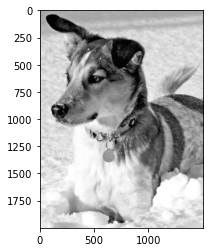

In [47]:
#
# Lecture de l'image parmi dog.jpg et jupiter.jpg [couleur] 
#
#
imgc = Image.open("dog.jpg")

#
# Conversion de l'image RGB en mode gris et normalisation
#
img      = np.array(imgc)
R        = img[:, :, 0]
G        = img[:, :, 1]
B        = img[:, :, 2]
img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
M        = (1./255)*np.array(img_gray)
#
# Affichage de la taille de l'image et de l'image en gris si besoin
#
print(np.shape(M))
plt.imshow(M,'gray')
#
# Constantes utiles par la suite
#
m     = np.shape(M)[0] # nombre de lignes de la matrice M
n     = np.shape(M)[1] # nombre de colonnes de la matrice M

Time spent in the determination of the approximated rank 0.41127514839172363
Estimated rank:  768  for relative threshold:  0.01
Time spent in the randomized CUR algorithm 0.754518985748291
Time spent in the double sided ID algorithm 0.9322280883789062
Time spent in the CUR algorithm 0.9413290023803711


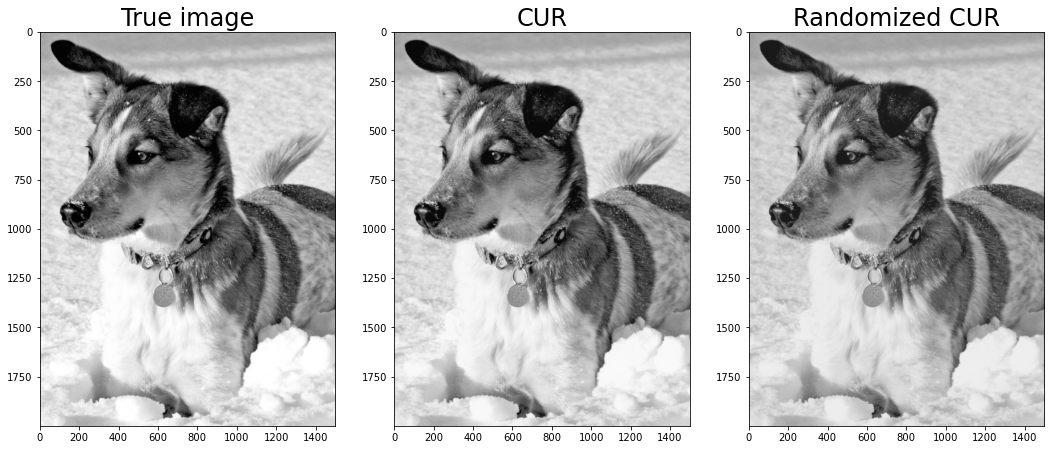

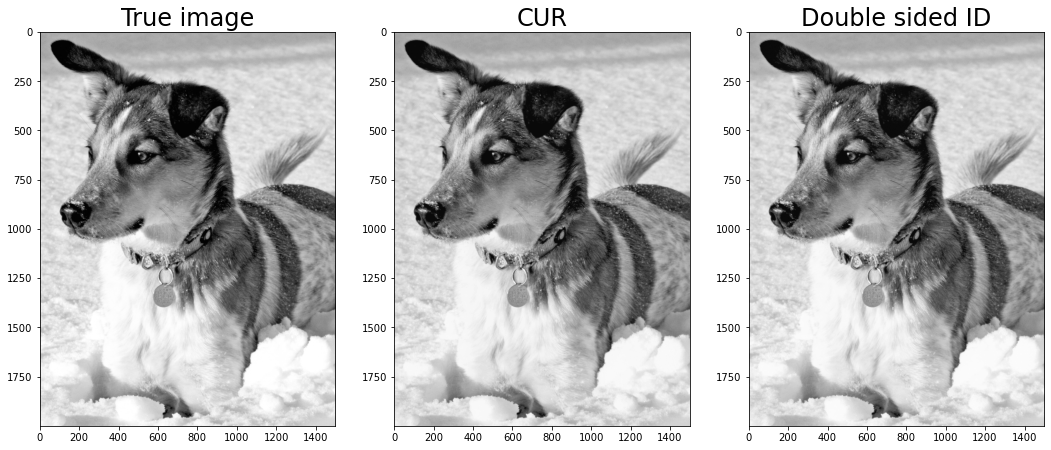

In [48]:
#
# Application of the ID/CUR algorithms to M with erank as target rank
#
epsilon  = 1.e-2
blocking = 128
t_start  = time.time()
Q, erank = adaptive_rank_determination(M,epsilon,blocking)
print("Time spent in the determination of the approximated rank",time.time()-t_start) 
print("Estimated rank: ",erank, " for relative threshold: ",epsilon)
#
# Randomized CUR algorithm
#
p = 5
q = 1
t_start        = time.time()
I, J, C, U, R  = randomized_cur(M,erank,p,q)
JCUR_R         = C@U@R
print("Time spent in the randomized CUR algorithm",time.time()-t_start) 
#
# Double sided ID
#
t_start        = time.time()
I,J,X,Z        = double_sided_ID(M,erank)
JID            = X @ extract_subblock(M,I,J) @ Z
print("Time spent in the double sided ID algorithm",time.time()-t_start)
#
# CUR algorithm
#
t_start        = time.time()
I,J,C, U, R    = cur(M,erank)
JCUR_D         = C@U@R
print("Time spent in the CUR algorithm",time.time()-t_start)
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JCUR_R,'gray')
plt.title('Randomized CUR',fontsize=24)
plt.show()

plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

(3207, 2260)


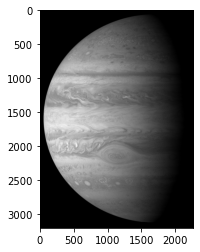

In [49]:
#
# Lecture de l'image parmi dog.jpg et jupiter.jpg [couleur] 
#
#
imgc = Image.open("jupiter.jpg")

#
# Conversion de l'image RGB en mode gris et normalisation
#
img      = np.array(imgc)
R        = img[:, :, 0]
G        = img[:, :, 1]
B        = img[:, :, 2]
img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
M         = (1./255)*np.array(img_gray)
print(np.shape(M))
plt.imshow(M,'gray')
#
# Constantes utiles par la suite
#
m     = np.shape(M)[0] # nombre de lignes de la matrice M
n     = np.shape(M)[1] # nombre de colonnes de la matrice M

Time spent in the determination of the approximated rank 1.8446459770202637
Estimated rank:  1920  for relative threshold:  0.001
Time spent in the randomized CUR algorithm 6.971408128738403
Time spent in the double sided ID algorithm 5.870038032531738
Time spent in the CUR algorithm 6.419936895370483


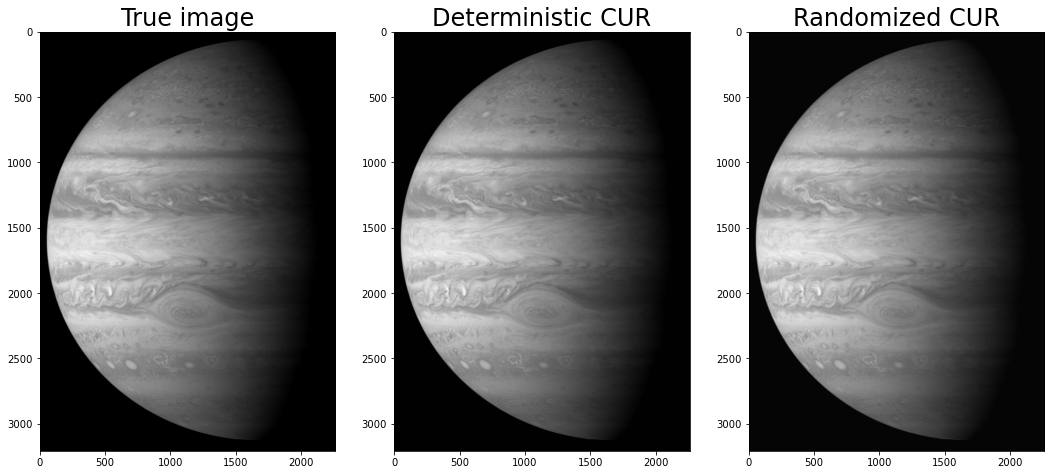

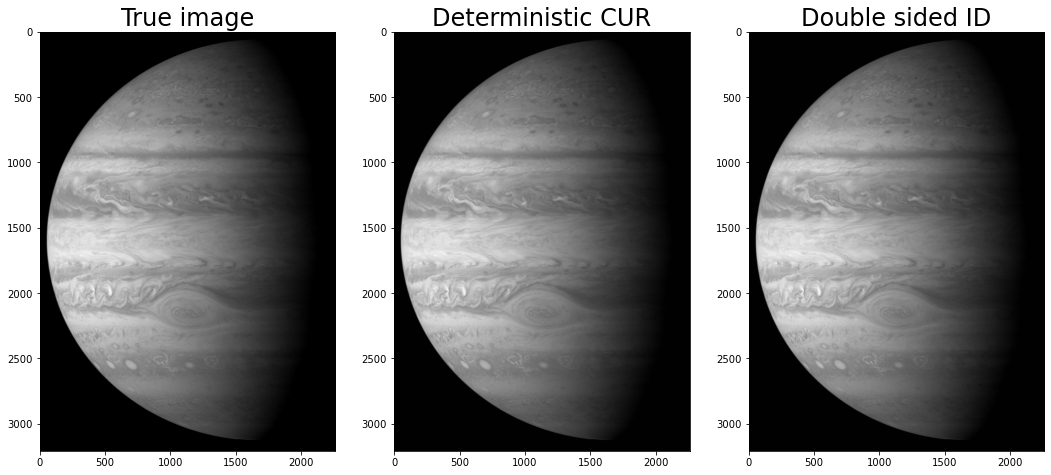

In [50]:
#
# Application of the ID/CUR algorithms to M with erank as target rank
#
epsilon  = 1.e-3
blocking = 128
t_start  = time.time()
Q, erank = adaptive_rank_determination(M,epsilon,blocking)
print("Time spent in the determination of the approximated rank",time.time()-t_start) 
print("Estimated rank: ",erank, " for relative threshold: ",epsilon)
#
# Randomized CUR algorithm
#
p = 5
q = 1
t_start        = time.time()
I,J,C, U, R    = randomized_cur(M,erank,p,q)
JCUR_R         = C@U@R
print("Time spent in the randomized CUR algorithm",time.time()-t_start) 
#
# Double sided ID
#
t_start  = time.time()
I,J,X,Z  = double_sided_ID(M,erank)
JID      = X @ extract_subblock(M,I,J) @ Z
print("Time spent in the double sided ID algorithm",time.time()-t_start)
#
# CUR algorithm
#
t_start        = time.time()
I,J,C, U, R    = cur(M,erank)
JCUR_D         = C@U@R
print("Time spent in the CUR algorithm",time.time()-t_start)
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('Deterministic CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JCUR_R,'gray')
plt.title('Randomized CUR',fontsize=24)
plt.show()

plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('Deterministic CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

**Commentaires:**

## Partie C.

En vous basant notamment sur les notes de cours, les chapitres 10 et 11 de <a href="https://arxiv.org/pdf/1607.01649.pdf">Martinsson (2019)</a>, la section 13 de <a href="https://arxiv.org/pdf/2002.01387.pdf">Martinsson et Tropp (2020)</a>,  répondre aux questions suivantes:

* C.1 Donner les avantages et inconvénients éventuels de la décomposition ID (version déterministe colonne, ligne ou double) ? 

**Réponse**:
1. Les avantages éventuels de la décomposition ID sont :
    * La décomposition ID nécessite moins de mémoire de stockage que QR ou SVD.
    * La recherche des indices associés aux colonnes de recouvrement est souvent utile pour l'interprétation des données.
    * Dans le contexte des algorithmes numériques de discrétisation des PDE et des équations intégrales, la décomposition ID préserve souvent «la physique» d'un problème d'une manière que les QR ou SVD ne font pas.
    
2. L'inconvénient de la décomposition ID est que lorsque A n'est pas précisément du rang k, alors l'erreur d'approximation par le meilleur ID de rang k possible peut être sensiblement plus grande que l'erreur théoriquement minimale.
    

* C.2 Quelle est la complexité opératoire de la méthode colonne ID (version déterministe) ? Justifier ce résultat dans le cas d'une matrice dense $A \in \mathbb{R}^{m \times n}$. Vous pourrez par exemple détailler la complexité étape par étape pour plus de clarté en vous basant sur une méthode QR avec pivotage de colonne pour obtenir cette décomposition. 

**Réponse**: Pour calculer la complexité opératoire de la méthode colonne ID (version déterministe) on suit les étapes suivantes :
1. Calcul de la complexité de la décomposition QR et qui est : $O(m.n.min(m,n))$
2. Calcul de la complexité de la résolution du système triangulaire et qui est : $O(k^2(m-k))$
3. Calcul de la complexité de la méthode et qui est la somme des deux complexités et en simplifiant, on retrouve le résultat :
$O(m.n.min(m,n))$


* C.3 Quel théoreme permet d'affirmer que $\sigma_{k+1}(A) \le \| E \|_2$ avec $E$ la matrice d'erreur d'approximation lors de la construction d'une approximation de rang $k$ obtenue avec toute méthode basée sur la décomposition interpolative ID ? 

**Réponse**: Le théoreme qui permet d'affirmer que $\sigma_{k+1}(A) \le \| E \|_2$ est **Eckart–Young–Mirsky**

* C.4 Quel est selon vous l'avantage principal des méthodes ID par rapport aux méthodes basées sur la décomposition CUR-ID ? Vous pourrez baser votre raisonnement et votre analyse sur l'expérimentation numérique proposée en Partie B.

**Réponse**: On remarque d'après les tests que l'erreur approximative pour les méthodes ID est de l'ordre de $10^{-16}$, par contre cette erreur est de l'ordre de $10^{-15}$ pour les autres méthodes.
On conclue donc que l'avantage principal des méthodes ID par rapport aux méthodes basées sur la décomposition CUR-ID est que son erreur approximative est le plus faible et donc une meilleure qualité.


* C.5 Expliquer les raisons qui ont conduit à proposer des variantes aléatoires de ces algorithmes ?

**Réponse**: Les raisons qui ont conduit à proposer des variantes aléatoires de ces algorithmes s'agissent dans le faite que ces variantes aléatoires sont moins couteuses puisque la complexité est plus faible.

## Partie D.

### Références (articles et exposés)

### Articles

* P.-G.  Martinsson.  <a href="https://arxiv.org/pdf/1607.01649.pdf">Randomized  methods  for  matrix  computations</a>.  In  M.W.  Mahoney,  J.C.  Duchi,  and  A.C.  Gilbert, editors, The Mathematics of Data, volume 25, chapter 4, pages 187 – 231. American Mathematical Society, IAS/ParkCity Mathematics Series, 2018.


* P.-G.  Martinsson and J. Tropp.  <a href="https://arxiv.org/pdf/2002.01387.pdf">Randomized Numerical Linear Algebra: Foundations & Algorithms</a>. Acta Numerica, 29, pp 403-572, 2020.


* S. Voronin, P.-G.  Martinsson and  <a href="https://users.oden.utexas.edu/~pgm/Pubs/2017_voronin_CUR.pdf">Efficient Algorithms for CUR and Interpolative Matrix Decompositions</a>. Advances in Computational Mathematics, Volume 43, Issue 3, pp 495–516, 2017.

### Exposés

* P.-G.  Martinsson. <a href="https://simons.berkeley.edu/talks/randomized-algorithms-computing-full-matrix-factorizations">Randomized Algorithms for Computing Full Matrix Factorizations</a>, talk given at  
Randomized Numerical Linear Algebra and Applications, September 2018, Simons Institute, Berkeley, 2018.


* P.-G.  Martinsson. <a href="https://www.youtube.com/watch?v=l262Qij6flM">Randomized algorithms for pivoting and for computing interpolatory and CUR factorizations</a>, talk given at E-Numerical Linear Algebra seminars, March 2021.
